# Install Libraries

In [ ]:
!pip install gluonts
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import RobustScaler
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.npts import NPTSPredictor

# Read Train, product, and service_delivery_site_data CSV files and merge files

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/chencba/ContracetivesConsumptionPrediction/main/Train.csv")
df[:5]

,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,75,0,21,-54,0,18,0,100.0
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3,0,3,0,0,2,0,10.0
2,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27000,0,75,22,0,53,9,0,0.0
3,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27137,2,0,0,0,2,0,0,0.0
4,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27138,45,0,2,0,43,1,0,0.0


In [ ]:
product = pd.read_csv("https://raw.githubusercontent.com/chencba/ContracetivesConsumptionPrediction/main/product.csv")
df = df.merge(product, on = "product_code")

site = pd.read_csv("https://raw.githubusercontent.com/chencba/ContracetivesConsumptionPrediction/main/service_delivery_site_data.csv")
df = df.merge(site, on = "site_code")

df.drop(["site_region", "site_district"], axis = 1, inplace = True)

df.drop(["stock_stockout_days", "stock_adjustment", "site_latitude", "site_longitude", "product_name", "stock_ordered", "stock_end", "stock_initial", "average_monthly_consumption", "stock_received"], axis = 1, inplace = True)

df[:5]

,year,month,region,district,site_code,product_code,stock_distributed,product_type,site_type
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,21,Injectable Contraceptive,Hospital
1,2019,2,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,0,Injectable Contraceptive,Hospital
2,2019,3,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,0,Injectable Contraceptive,Hospital
3,2019,4,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,2,Injectable Contraceptive,Hospital
4,2019,5,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,31,Injectable Contraceptive,Hospital


In [ ]:
df["year"] = df["year"].astype(str)
df["month"] = df["month"].astype(str)

df["year_month"] = df["year"] + df["month"]
df["year_month"] = df["year_month"].apply(lambda x: datetime.datetime.strptime(x, "%Y%m"))

df["site_product"] = df["site_code"] + " X " + df["product_code"]

df[:5]

,year,month,region,district,site_code,product_code,stock_distributed,product_type,site_type,year_month,site_product
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,21,Injectable Contraceptive,Hospital,2019-01-01,C4001 X AS27134
1,2019,2,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,0,Injectable Contraceptive,Hospital,2019-02-01,C4001 X AS27134
2,2019,3,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,0,Injectable Contraceptive,Hospital,2019-03-01,C4001 X AS27134
3,2019,4,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,2,Injectable Contraceptive,Hospital,2019-04-01,C4001 X AS27134
4,2019,5,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,31,Injectable Contraceptive,Hospital,2019-05-01,C4001 X AS27134


# Load Submission file

In [ ]:
submissions = pd.read_csv("https://raw.githubusercontent.com/chencba/ContracetivesConsumptionPrediction/main/SampleSubmission.csv")
submissions[:5]

,ID,prediction
0,2019 X 7 X C4001 X AS21126,0
1,2019 X 7 X C4001 X AS27134,0
2,2019 X 7 X C4001 X AS27132,0
3,2019 X 7 X C4001 X AS27000,0
4,2019 X 7 X C4001 X AS27137,0


# Main DataFrame Preprocessing

Add new features (interaction terms)

In [ ]:
df["year_region"] = df["year"] + "_" + df["region"]
df["year_site"] = df["year"] + "_" + df["site_code"]
df["year_siteproduct"] = df["year"] + "_" + df["site_product"]
df["month_region"] = df["month"] + "_" + df["region"]
df["month_siteproduct"] = df["month"] + "_" + df["site_product"]
df["district_region"] = df["district"] + "_" + df["region"]
df["site_region"] = df["site_code"] + "_" + df["region"]
df["product_region"] = df["product_code"] + "_" + df["region"]
df["producttype_region"] = df["product_type"] + "_" + df["region"]
#df["siteproduct_region"] = df["site_product"] + "_" + df["region"]
df["district_site"] = df["district"] + "_" + df["site_code"]
df["district_product"] = df["district"] + "_" + df["product_code"]
df["district_sitetype"] = df["district"] + "_" + df["site_type"]
df["district_producttype"] = df["district"] + "_" + df["product_type"]
#df["district_siteproduct"] = df["district"] + "_" + df["site_product"]
df["site_sitetype"] = df["site_code"] + "_" + df["site_type"]
df["site_producttype"] = df["site_code"] + "_" + df["product_type"]
#df["site_siteproduct"] = df["site_code"] + "_" + df["site_product"]
df["product_sitetype"] = df["product_code"] + "_" + df["site_type"]
df["product_producttype"] = df["product_code"] + "_" + df["product_type"]
#df["product_siteproduct"] = df["product_code"] + "_" + df["site_product"]
df["sitetype_producttype"] = df["site_type"] + "_" + df["product_type"]
#df["sitetype_siteproduct"] = df["site_type"] + "_" + df["site_product"]
#df["producttype_siteproduct"] = df["product_type"] + "_" + df["site_product"]

In [ ]:
"""
# prepare for unseen category
df.loc[len(df)] = ["unseen", "unseen", "unseen", "unseen", "unseen", "unseen", 0, "unseen", "unseen", "unseen", "unseen"]
"""

'\n# prepare for unseen category\ndf.loc[len(df)] = ["unseen", "unseen", "unseen", "unseen", "unseen", "unseen", 0, "unseen", "unseen", "unseen", "unseen"]\n'

Encode labels for categorical features

In [ ]:
encoders = {}

for col in ["year", "month", "region", "district", "site_code", "product_code", "product_type", "site_type", "site_product", "year_region", "year_site", "year_siteproduct", "month_region", "month_siteproduct", "district_region", "site_region", "product_region", "producttype_region", "district_site", "district_product", "district_sitetype", "district_producttype", "site_sitetype", "site_producttype", "product_sitetype", "product_producttype", "sitetype_producttype"]:
  unique_values = list(df[col].unique())
  #submissions[col] = [x if x in unique_values else 'unseen' for x in submissions[col]]
  le = LabelEncoder().fit(unique_values)
  encoders[col] = le
  df[col] = le.transform(df[[col]])
  #submissions[col] = le.transform(submissions[[col]])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df = df.set_index("year_month")

Refill DatetimeIndex for DataFrame

In [ ]:
df_list = []
new_index = pd.date_range("1/1/2016", end="6/1/2019", freq="MS")

for item_id, gdf in df.groupby("site_product"):
    dfs = gdf.reindex(new_index)
    dfs["site_product"].fillna(method = "bfill", inplace = True)
    dfs["site_product"].fillna(method = "ffill", inplace = True)
    dfs["site_type"].fillna(method = "bfill", inplace = True)
    dfs["site_type"].fillna(method = "ffill", inplace = True)
    dfs["product_type"].fillna(method = "bfill", inplace = True)
    dfs["product_type"].fillna(method = "ffill", inplace = True)
    dfs["product_code"].fillna(method = "bfill", inplace = True)
    dfs["product_code"].fillna(method = "ffill", inplace = True)
    dfs["site_code"].fillna(method = "bfill", inplace = True)
    dfs["site_code"].fillna(method = "ffill", inplace = True)
    dfs["district"].fillna(method = "bfill", inplace = True)
    dfs["district"].fillna(method = "ffill", inplace = True)
    dfs["region"].fillna(method = "bfill", inplace = True)
    dfs["region"].fillna(method = "ffill", inplace = True)
    dfs["year"].fillna(method = "bfill", inplace = True)
    dfs["year"].fillna(method = "ffill", inplace = True) 
    dfs["month"].fillna(method = "bfill", inplace = True)
    dfs["month"].fillna(method = "ffill", inplace = True)
    dfs["year_region"].fillna(method = "bfill", inplace = True)
    dfs["year_region"].fillna(method = "ffill", inplace = True) 
    dfs["year_site"].fillna(method = "bfill", inplace = True)
    dfs["year_site"].fillna(method = "ffill", inplace = True)
    dfs["year_siteproduct"].fillna(method = "bfill", inplace = True)
    dfs["year_siteproduct"].fillna(method = "ffill", inplace = True)
    dfs["month_region"].fillna(method = "bfill", inplace = True)
    dfs["month_region"].fillna(method = "ffill", inplace = True)
    dfs["month_siteproduct"].fillna(method = "bfill", inplace = True)
    dfs["month_siteproduct"].fillna(method = "ffill", inplace = True) 
    dfs["district_region"].fillna(method = "bfill", inplace = True)
    dfs["district_region"].fillna(method = "ffill", inplace = True)
    dfs["site_region"].fillna(method = "bfill", inplace = True)
    dfs["site_region"].fillna(method = "ffill", inplace = True) 
    dfs["product_region"].fillna(method = "bfill", inplace = True)
    dfs["product_region"].fillna(method = "ffill", inplace = True)
    dfs["producttype_region"].fillna(method = "bfill", inplace = True)
    dfs["producttype_region"].fillna(method = "ffill", inplace = True)
    #dfs["siteproduct_region"].fillna(method = "bfill", inplace = True)
    #dfs["siteproduct_region"].fillna(method = "ffill", inplace = True)
    dfs["district_site"].fillna(method = "bfill", inplace = True)
    dfs["district_site"].fillna(method = "ffill", inplace = True) 
    dfs["district_product"].fillna(method = "bfill", inplace = True)
    dfs["district_product"].fillna(method = "ffill", inplace = True)
    dfs["district_sitetype"].fillna(method = "bfill", inplace = True)
    dfs["district_sitetype"].fillna(method = "ffill", inplace = True)
    dfs["district_producttype"].fillna(method = "bfill", inplace = True)
    dfs["district_producttype"].fillna(method = "ffill", inplace = True)
    #dfs["district_siteproduct"].fillna(method = "bfill", inplace = True)
    #dfs["district_siteproduct"].fillna(method = "ffill", inplace = True)
    dfs["site_sitetype"].fillna(method = "bfill", inplace = True)
    dfs["site_sitetype"].fillna(method = "ffill", inplace = True)
    dfs["site_producttype"].fillna(method = "bfill", inplace = True)
    dfs["site_producttype"].fillna(method = "ffill", inplace = True) 
    #dfs["site_siteproduct"].fillna(method = "bfill", inplace = True)
    #dfs["site_siteproduct"].fillna(method = "ffill", inplace = True)
    dfs["product_sitetype"].fillna(method = "bfill", inplace = True)
    dfs["product_sitetype"].fillna(method = "ffill", inplace = True) 
    dfs["product_producttype"].fillna(method = "bfill", inplace = True)
    dfs["product_producttype"].fillna(method = "ffill", inplace = True)
    #dfs["product_siteproduct"].fillna(method = "bfill", inplace = True)
    #dfs["product_siteproduct"].fillna(method = "ffill", inplace = True)
    dfs["sitetype_producttype"].fillna(method = "bfill", inplace = True)
    dfs["sitetype_producttype"].fillna(method = "ffill", inplace = True)
    #dfs["sitetype_siteproduct"].fillna(method = "bfill", inplace = True)
    #dfs["sitetype_siteproduct"].fillna(method = "ffill", inplace = True) 
    #dfs["producttype_siteproduct"].fillna(method = "bfill", inplace = True)
    #dfs["producttype_siteproduct"].fillna(method = "ffill", inplace = True)
    #dfs["average_monthly_consumption"].fillna(0, inplace = True)
    #dfs["stock_initial"].fillna(0, inplace = True)
    #dfs["stock_received"].fillna(0, inplace = True)
    dfs["stock_distributed"].fillna(0, inplace = True)
    df_list.append(dfs)

df = pd.concat(df_list)

In [ ]:
df[:5]

,year,month,region,district,site_code,product_code,stock_distributed,product_type,site_type,site_product,year_region,year_site,year_siteproduct,month_region,month_siteproduct,district_region,site_region,product_region,producttype_region,district_site,district_product,district_sitetype,district_producttype,site_sitetype,site_producttype,product_sitetype,product_producttype,sitetype_producttype
2016-01-01,3.0,6.0,2.0,6.0,0.0,1.0,0.0,3.0,1.0,0.0,62.0,429.0,3003.0,122.0,6736.0,6.0,0.0,22.0,62.0,21.0,59.0,10.0,37.0,0.0,2.0,4.0,1.0,10.0
2016-02-01,3.0,6.0,2.0,6.0,0.0,1.0,0.0,3.0,1.0,0.0,62.0,429.0,3003.0,122.0,6736.0,6.0,0.0,22.0,62.0,21.0,59.0,10.0,37.0,0.0,2.0,4.0,1.0,10.0
2016-03-01,3.0,6.0,2.0,6.0,0.0,1.0,0.0,3.0,1.0,0.0,62.0,429.0,3003.0,122.0,6736.0,6.0,0.0,22.0,62.0,21.0,59.0,10.0,37.0,0.0,2.0,4.0,1.0,10.0
2016-04-01,3.0,6.0,2.0,6.0,0.0,1.0,0.0,3.0,1.0,0.0,62.0,429.0,3003.0,122.0,6736.0,6.0,0.0,22.0,62.0,21.0,59.0,10.0,37.0,0.0,2.0,4.0,1.0,10.0
2016-05-01,3.0,6.0,2.0,6.0,0.0,1.0,0.0,3.0,1.0,0.0,62.0,429.0,3003.0,122.0,6736.0,6.0,0.0,22.0,62.0,21.0,59.0,10.0,37.0,0.0,2.0,4.0,1.0,10.0


In [ ]:
"""
submissions = submissions.set_index("year_month")

submissions_temp = submissions[submissions["site_product"]!=1343]
#submissions_temp2 = submissions[submissions["site_product"]==1343]
submissions_list = []
new_index = pd.date_range("7/1/2019", end="9/1/2019", freq="MS")

for item_id, gdf in submissions_temp.groupby("site_product"):
    dfs = gdf.reindex(new_index)
    dfs["site_product"].fillna(method = "bfill", inplace = True)
    dfs["site_product"].fillna(method = "ffill", inplace = True)
    dfs["site_type"].fillna(method = "bfill", inplace = True)
    dfs["site_type"].fillna(method = "ffill", inplace = True)
    dfs["product_type"].fillna(method = "bfill", inplace = True)
    dfs["product_type"].fillna(method = "ffill", inplace = True)
    dfs["product_code"].fillna(method = "bfill", inplace = True)
    dfs["product_code"].fillna(method = "ffill", inplace = True)
    dfs["site_code"].fillna(method = "bfill", inplace = True)
    dfs["site_code"].fillna(method = "ffill", inplace = True)
    dfs["district"].fillna(method = "bfill", inplace = True)
    dfs["district"].fillna(method = "ffill", inplace = True)
    dfs["region"].fillna(method = "bfill", inplace = True)
    dfs["region"].fillna(method = "ffill", inplace = True)
    dfs["year"].fillna(method = "bfill", inplace = True)
    dfs["year"].fillna(method = "ffill", inplace = True) 
    dfs["month"].fillna(method = "bfill", inplace = True)
    dfs["month"].fillna(method = "ffill", inplace = True) 
    submissions_list.append(dfs)

submissions_temp = pd.concat(submissions_list)

submissions_temp = PandasDataset.from_long_dataframe(submissions_temp, target="prediction", item_id="site_product", feat_static_cat=["year","month","region","district","site_type","product_type","site_code","product_code"])
"""

'\nsubmissions = submissions.set_index("year_month")\n\nsubmissions_temp = submissions[submissions["site_product"]!=1343]\n#submissions_temp2 = submissions[submissions["site_product"]==1343]\nsubmissions_list = []\nnew_index = pd.date_range("7/1/2019", end="9/1/2019", freq="MS")\n\nfor item_id, gdf in submissions_temp.groupby("site_product"):\n    dfs = gdf.reindex(new_index)\n    dfs["site_product"].fillna(method = "bfill", inplace = True)\n    dfs["site_product"].fillna(method = "ffill", inplace = True)\n    dfs["site_type"].fillna(method = "bfill", inplace = True)\n    dfs["site_type"].fillna(method = "ffill", inplace = True)\n    dfs["product_type"].fillna(method = "bfill", inplace = True)\n    dfs["product_type"].fillna(method = "ffill", inplace = True)\n    dfs["product_code"].fillna(method = "bfill", inplace = True)\n    dfs["product_code"].fillna(method = "ffill", inplace = True)\n    dfs["site_code"].fillna(method = "bfill", inplace = True)\n    dfs["site_code"].fillna(method 

# Prepare Train & Validation & Test Sets

In [ ]:
df_train = df.copy(deep=True).loc[df.index < "2019-04-01"]
df_val = df.copy(deep=True).loc[(df.index > "2019-03-01") & (df.index < "2019-07-01")]
df_test = df.copy(deep=True)

"""
transformer = RobustScaler().fit(df_train[["stock_initial", "average_monthly_consumption", "stock_received"]])
df_train.loc[:,["stock_initial", "average_monthly_consumption", "stock_received"]] = transformer.transform(df_train[["stock_initial", "average_monthly_consumption", "stock_received"]])
df_val.loc[:,["stock_initial", "average_monthly_consumption", "stock_received"]] = transformer.transform(df_val[["stock_initial", "average_monthly_consumption", "stock_received"]])
df_test.loc[:,["stock_initial", "average_monthly_consumption", "stock_received"]] = transformer.transform(df_test[["stock_initial", "average_monthly_consumption", "stock_received"]])
"""

'\ntransformer = RobustScaler().fit(df_train[["stock_initial", "average_monthly_consumption", "stock_received"]])\ndf_train.loc[:,["stock_initial", "average_monthly_consumption", "stock_received"]] = transformer.transform(df_train[["stock_initial", "average_monthly_consumption", "stock_received"]])\ndf_val.loc[:,["stock_initial", "average_monthly_consumption", "stock_received"]] = transformer.transform(df_val[["stock_initial", "average_monthly_consumption", "stock_received"]])\ndf_test.loc[:,["stock_initial", "average_monthly_consumption", "stock_received"]] = transformer.transform(df_test[["stock_initial", "average_monthly_consumption", "stock_received"]])\n'

Use "site_product" column as unique identifier (item_id)

In [ ]:
feat_static_category = ["year", "month", "region", "district", "site_code", "product_code", "product_type", "site_type", "year_region", "year_site", "year_siteproduct", "month_region", "month_siteproduct", "district_region", "site_region", "product_region", "producttype_region", "district_site", "district_product", "district_sitetype", "district_producttype", "site_sitetype", "site_producttype", "product_sitetype", "product_producttype", "sitetype_producttype"]

ds_train = PandasDataset.from_long_dataframe(df_train, target="stock_distributed", item_id="site_product", feat_static_cat=feat_static_category)
ds_val = PandasDataset.from_long_dataframe(df_val, target="stock_distributed", item_id="site_product", feat_static_cat=feat_static_category)
ds_test = PandasDataset.from_long_dataframe(df_test, target="stock_distributed", item_id="site_product", feat_static_cat=feat_static_category)
# feat_dynamic_real=["stock_initial", "average_monthly_consumption", "stock_received"]

In [ ]:
next(iter(ds_test))

{'feat_static_cat': array([   3,    6,    2,    6,    0,    1,    3,    1,   62,  429, 3003,
         122, 6736,    6,    0,   22,   62,   21,   59,   10,   37,    0,
           2,    4,    1,   10], dtype=int32),
 'item_id': 0.0,
 'start': Period('2016-01', 'M'),
 'target': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}

# Model Configuration

In [ ]:
freq = "M"
prediction_length = 3

callbacks = [
    LearningRateReduction(objective="min",
               patience=10,
               base_lr=1e-2,
               decay_factor=0.5,
               ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]

# Trainer parameters
epochs = 10
learning_rate = 1E-2
batch_size = 128
num_batches_per_epoch = 100
#clip_gradient = 5.4848
#weight_decay = 0.001

trainer = Trainer(ctx="cpu",
          epochs=epochs,
          learning_rate=learning_rate,
          hybridize=True,
          batch_size=batch_size,
          num_batches_per_epoch=num_batches_per_epoch,
          callbacks=callbacks
          )

# DeepAR Modeling

In [ ]:
# Deep AR 

# create estimator
deepar_estimator = DeepAREstimator(freq=freq, 
              context_length=2*prediction_length,
              prediction_length=prediction_length,
              use_feat_static_cat=True,
              use_feat_dynamic_real=False,
              cardinality=[4,12,20,80,3,7,155,11,80,583,4123,240,13524,80,155,218,139,155,759,100,470,155,819,33,11,21],
              num_layers=2,
              num_cells=32,
              cell_type='lstm',
              scaling=True,
              #dropout_rate=0.1,
              trainer=trainer
              )

deepar_predictor = deepar_estimator.train(training_data = ds_train, validation_data = ds_val)

100%|██████████| 100/100 [00:09<00:00, 11.00it/s, epoch=1/10, avg_epoch_loss=2.28]
42it [00:02, 19.63it/s, epoch=1/10, validation_avg_epoch_loss=18.6]
100%|██████████| 100/100 [00:08<00:00, 11.37it/s, epoch=2/10, avg_epoch_loss=2]
42it [00:02, 19.71it/s, epoch=2/10, validation_avg_epoch_loss=13.7]
100%|██████████| 100/100 [00:08<00:00, 11.21it/s, epoch=3/10, avg_epoch_loss=1.27]
42it [00:02, 19.65it/s, epoch=3/10, validation_avg_epoch_loss=12.4]
100%|██████████| 100/100 [00:11<00:00,  8.64it/s, epoch=4/10, avg_epoch_loss=1.4]
42it [00:02, 16.72it/s, epoch=4/10, validation_avg_epoch_loss=11.9]
100%|██████████| 100/100 [00:10<00:00,  9.86it/s, epoch=5/10, avg_epoch_loss=0.742]
42it [00:02, 19.29it/s, epoch=5/10, validation_avg_epoch_loss=11.2]
100%|██████████| 100/100 [00:09<00:00, 11.07it/s, epoch=6/10, avg_epoch_loss=0.866]
42it [00:02, 19.63it/s, epoch=6/10, validation_avg_epoch_loss=12]
100%|██████████| 100/100 [00:08<00:00, 11.21it/s, epoch=7/10, avg_epoch_loss=0.993]
42it [00:02, 1

# DeepAR Evaluation

In [ ]:
deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
        dataset=ds_test,  # test dataset
        predictor=deepar_predictor,  # predictor
)

forecasts = list(deepar_forecast_it)
tss = list(deepar_ts_it)

In [ ]:
#evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
deepar_evaluator = Evaluator(quantiles=[0.25, 0.5, 0.75])
deepar_agg_metrics, deepar_item_metrics = deepar_evaluator(iter(tss), iter(forecasts), num_series=len(ds_test))

Running evaluation: 100%|██████████| 1343/1343 [00:00<00:00, 14577.76it/s]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]
/usr/local/lib/python3.7/dis

Agrregated Metrics

In [ ]:
deepar_agg_metrics

{'Coverage[0.25]': 0.06577314470091834,
 'Coverage[0.5]': 0.21245966741126834,
 'Coverage[0.75]': 0.5346239761727476,
 'MAE_Coverage': 0.22904773723835525,
 'MAPE': 0.8296769611205416,
 'MASE': inf,
 'MSE': 522.620954531032,
 'MSIS': inf,
 'ND': 0.67395735315462,
 'NRMSE': 1.7965005700821728,
 'OWA': nan,
 'QuantileLoss[0.25]': 23100.93829161013,
 'QuantileLoss[0.5]': 34553.793526445355,
 'QuantileLoss[0.75]': 36175.33990930421,
 'RMSE': 22.860904499407543,
 'abs_error': 34553.79349623737,
 'abs_target_mean': 12.72524199553239,
 'abs_target_sum': 51270.0,
 'mean_absolute_QuantileLoss': 31276.690575786564,
 'mean_wQuantileLoss': 0.6100388253517958,
 'sMAPE': 1.5910556208639117,
 'seasonal_error': 10.63886820551005,
 'wQuantileLoss[0.25]': 0.45057418161907803,
 'wQuantileLoss[0.5]': 0.6739573537438143,
 'wQuantileLoss[0.75]': 0.7055849406924948}

Metrics for each item_id

In [ ]:
deepar_item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.25],Coverage[0.25],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.75],Coverage[0.75]
0,0.0,0.001360,0.067545,0.0,0.000000,0.000000,inf,NaN,2.000000,inf,inf,0.066572,0.000000,0.067545,0.000000,0.013949,0.666667
1,1.0,308.550578,40.933064,94.0,31.333333,17.740741,0.769097,0.373112,0.502695,0.435458,8.726327,43.618238,0.000000,40.933062,0.333333,20.774248,0.666667
2,2.0,1.123152,2.522943,3.0,1.000000,2.555556,0.329079,0.387817,0.997963,0.840981,3.374126,1.822380,0.333333,2.522943,0.333333,1.617640,1.000000
3,3.0,2567.636719,155.291473,200.0,66.666667,14.222222,3.639644,0.773451,1.262014,0.776457,16.371105,95.695368,0.000000,155.291470,0.000000,164.561116,0.000000
4,4.0,3.047455,3.106196,0.0,0.000000,39.185185,0.026423,NaN,2.000000,inf,0.868990,1.640912,0.000000,3.106196,0.666667,6.554184,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,1338.0,0.000033,0.009832,0.0,0.000000,5.222222,0.000628,NaN,2.000000,inf,0.006144,0.012684,0.333333,0.009832,0.666667,0.006447,1.000000
1339,1339.0,141.944275,24.479801,24.0,8.000000,1.333333,6.119950,0.997064,1.992207,1.019992,126.881561,12.247243,0.000000,24.479801,0.333333,35.255385,0.333333
1340,1340.0,0.000069,0.022003,0.0,0.000000,0.000000,inf,NaN,2.000000,inf,inf,0.023427,0.000000,0.022003,0.000000,0.004201,0.000000
1341,1341.0,0.000046,0.019368,0.0,0.000000,0.000000,inf,NaN,2.000000,inf,inf,0.021261,0.000000,0.019368,0.000000,0.001566,0.333333


item_id with big error (abs_error > 20)

In [ ]:
big_error = deepar_item_metrics[deepar_item_metrics["abs_error"]>=20]
big_error

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.25],Coverage[0.25],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.75],Coverage[0.75]
1,1.0,308.550578,40.933064,94.0,31.333333,17.740741,0.769097,0.373112,0.502695,0.435458,8.726327,43.618238,0.000000,40.933062,0.333333,20.774248,0.666667
3,3.0,2567.636719,155.291473,200.0,66.666667,14.222222,3.639644,0.773451,1.262014,0.776457,16.371105,95.695368,0.000000,155.291470,0.000000,164.561116,0.000000
5,5.0,315.076090,47.783070,67.0,22.333333,5.518519,2.886226,0.661372,1.016471,0.713180,11.308815,31.346450,0.000000,47.783070,0.000000,52.699427,0.333333
6,6.0,608.179199,64.934586,66.0,22.000000,5.296296,4.086792,0.988869,1.956328,0.983857,121.283008,33.259165,0.000000,64.934589,0.000000,94.749149,0.000000
11,11.0,730.653076,85.962044,174.0,58.000000,69.555556,0.411959,1.438670,0.683604,0.494035,4.086457,59.096034,0.333333,85.962044,0.333333,46.896202,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,1302.0,139.065745,38.406036,100.0,33.333333,22.777778,0.562040,0.367688,0.463223,0.384060,5.677918,31.411270,0.000000,38.406038,0.000000,17.357997,0.333333
1310,1310.0,741.009766,51.300125,108.0,36.000000,12.037037,1.420619,0.317187,0.442448,0.475001,29.118009,30.701437,0.000000,51.300125,0.333333,63.760774,0.666667
1317,1317.0,119.879913,34.317280,145.0,48.333333,22.666667,0.504666,0.243184,0.229223,0.236671,5.354787,14.791296,0.333333,34.317280,0.666667,22.397844,1.000000
1336,1336.0,309.782145,56.554035,67.0,22.333333,3.296296,5.718947,0.833991,1.440596,0.844090,66.636734,32.604123,0.000000,56.554035,0.000000,69.068907,0.000000


In [ ]:
big_error_id = big_error["item_id"].astype(int)

Draw time-series plots for random item_id

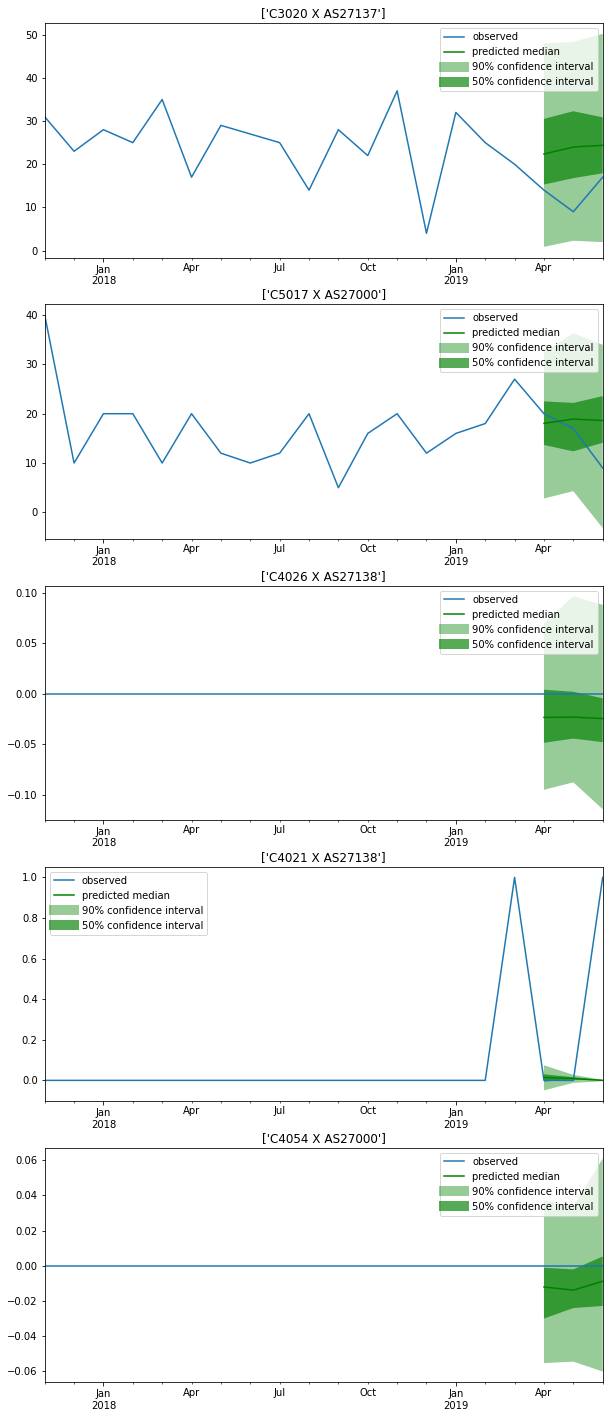

In [ ]:
n_plot = 5
indices = np.random.choice(np.arange(0, 1343, 1), size=n_plot, replace=False)

fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot*5))
for index, ax in zip(indices, axes):
    tss[index][-20:].plot(ax=ax)
    plt.sca(ax)
    forecasts[index].plot(color='g')
    name = encoders.get("site_product").inverse_transform([index])
    plt.title("{}".format(name))
    plt.legend(["observed", "predicted median", "90% confidence interval", "50% confidence interval"])

Draw time-series plots for item_id with big error

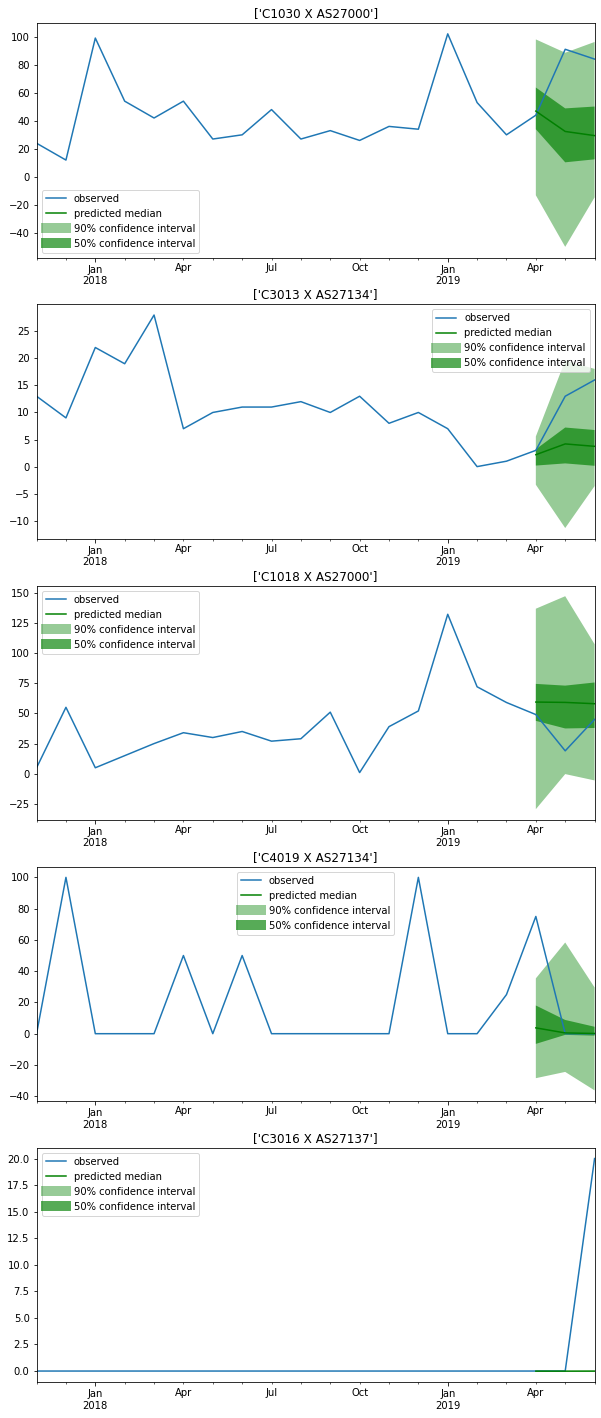

In [ ]:
n_plot = 5
indices = np.random.choice(big_error_id, size=n_plot, replace=False)

fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot*5))
for index, ax in zip(indices, axes):
    tss[index][-20:].plot(ax=ax)
    plt.sca(ax)
    forecasts[index].plot(color='g')
    name = encoders.get("site_product").inverse_transform([index])
    plt.title("{}".format(name))
    plt.legend(["observed", "predicted median", "90% confidence interval", "50% confidence interval"])

# DeepAR Prediction

In [ ]:
predictions = list(deepar_predictor.predict(ds_test))

In [ ]:
def sample_df(forecast):
  samples = forecast.samples
  dates = pd.date_range("7/1/2019", end="9/1/2019", freq="MS")
  return pd.DataFrame(samples.T, index=dates)

parts = [sample_df(entry).assign(entry=i) for i, entry in enumerate(predictions)]
predictions = pd.concat(parts)

In [ ]:
predictions.loc[:,"predicted_value"] = predictions.loc[:, 0:99].apply(np.median, axis=1)
predictions = predictions[["entry", "predicted_value"]]
predictions.loc[:,"site_product"] = encoders.get("site_product").inverse_transform(predictions["entry"])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
predictions["year"] = predictions.index.year.astype(str)
predictions["month"] = predictions.index.month.astype(str)
predictions["item"] = predictions["year"].astype(str) + " X " + predictions["month"].astype(str) + " X " + predictions["site_product"]
predictions["site"] = predictions["site_product"].str[:5]
predictions["product"] = predictions["site_product"].str[8:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
predictions.drop(["entry", "year"], axis = 1, inplace = True)

In [ ]:
predictions

,predicted_value,site_product,month,item,site,product
2019-07-01,-0.024132,C1004 X AS21126,7,2019 X 7 X C1004 X AS21126,C1004,AS21126
2019-08-01,-0.024388,C1004 X AS21126,8,2019 X 8 X C1004 X AS21126,C1004,AS21126
2019-09-01,-0.032819,C1004 X AS21126,9,2019 X 9 X C1004 X AS21126,C1004,AS21126
2019-07-01,21.468887,C1004 X AS27000,7,2019 X 7 X C1004 X AS27000,C1004,AS27000
2019-08-01,16.254581,C1004 X AS27000,8,2019 X 8 X C1004 X AS27000,C1004,AS27000
...,...,...,...,...,...,...
2019-08-01,-0.011424,C5066 X AS42018,8,2019 X 8 X C5066 X AS42018,C5066,AS42018
2019-09-01,-0.008335,C5066 X AS42018,9,2019 X 9 X C5066 X AS42018,C5066,AS42018
2019-07-01,-0.006398,C5066 X AS46000,7,2019 X 7 X C5066 X AS46000,C5066,AS46000
2019-08-01,-0.010689,C5066 X AS46000,8,2019 X 8 X C5066 X AS46000,C5066,AS46000


# Save predicted values into submission file

Merge submission file with predictions

In [ ]:
final_df = submissions.merge(predictions, how = "left", left_on = "ID", right_on = "item")

In [ ]:
final_df["year"] = final_df["ID"].str[:4]
final_df["month"] = final_df["ID"].str[7:8]
final_df["site"] = final_df["ID"].str[11:16]
final_df["product"] = final_df["ID"].str[19:26]

final_df[:5]

,ID,prediction,predicted_value,site_product,month,item,site,product,year
0,2019 X 7 X C4001 X AS21126,0,-0.008106,C4001 X AS21126,7,2019 X 7 X C4001 X AS21126,C4001,AS21126,2019
1,2019 X 7 X C4001 X AS27134,0,6.373184,C4001 X AS27134,7,2019 X 7 X C4001 X AS27134,C4001,AS27134,2019
2,2019 X 7 X C4001 X AS27132,0,0.149363,C4001 X AS27132,7,2019 X 7 X C4001 X AS27132,C4001,AS27132,2019
3,2019 X 7 X C4001 X AS27000,0,11.736695,C4001 X AS27000,7,2019 X 7 X C4001 X AS27000,C4001,AS27000,2019
4,2019 X 7 X C4001 X AS27137,0,0.000506,C4001 X AS27137,7,2019 X 7 X C4001 X AS27137,C4001,AS27137,2019


There are some new combinations which didn't appear in the training set. I will look for their values in the predictions using "product_code" and estimate the new value with the mean values.

In [ ]:
temp = final_df[final_df["item"].isnull()]
temp

,ID,prediction,predicted_value,site_product,month,item,site,product,year
162,2019 X 7 X C1679 X AS27138,0,NaN,NaN,7,NaN,C1679,AS27138,2019
182,2019 X 8 X C1679 X AS27138,0,NaN,NaN,8,NaN,C1679,AS27138,2019
194,2019 X 9 X C1679 X AS27138,0,NaN,NaN,9,NaN,C1679,AS27138,2019
565,2019 X 8 X C5015 X AS27138,0,NaN,NaN,8,NaN,C5015,AS27138,2019
571,2019 X 9 X C5015 X AS27138,0,NaN,NaN,9,NaN,C5015,AS27138,2019
623,2019 X 7 X C5017 X AS21126,0,NaN,NaN,7,NaN,C5017,AS21126,2019
630,2019 X 8 X C5017 X AS21126,0,NaN,NaN,8,NaN,C5017,AS21126,2019
637,2019 X 9 X C5017 X AS21126,0,NaN,NaN,9,NaN,C5017,AS21126,2019
733,2019 X 9 X C4016 X AS21126,0,NaN,NaN,9,NaN,C4016,AS21126,2019
888,2019 X 9 X C3015 X AS21126,0,NaN,NaN,9,NaN,C3015,AS21126,2019


In [ ]:
for i, j in zip(temp["product"], temp["month"]):
  idx = temp[(temp["product"]==i) & (temp["month"]==j)].index
  final_df.loc[idx, "predicted_value"] = predictions[(predictions["product"]==i) & (predictions["month"]==j)].predicted_value.mean()

Now we have all the predicted values.

In [ ]:
final_df.isnull().sum()

ID                  0
prediction          0
predicted_value     0
site_product       21
month               0
item               21
site                0
product             0
year                0
dtype: int64

In [ ]:
final_df[:5]

,ID,prediction,predicted_value,site_product,month,item,site,product,year
0,2019 X 7 X C4001 X AS21126,0,-0.008106,C4001 X AS21126,7,2019 X 7 X C4001 X AS21126,C4001,AS21126,2019
1,2019 X 7 X C4001 X AS27134,0,6.373184,C4001 X AS27134,7,2019 X 7 X C4001 X AS27134,C4001,AS27134,2019
2,2019 X 7 X C4001 X AS27132,0,0.149363,C4001 X AS27132,7,2019 X 7 X C4001 X AS27132,C4001,AS27132,2019
3,2019 X 7 X C4001 X AS27000,0,11.736695,C4001 X AS27000,7,2019 X 7 X C4001 X AS27000,C4001,AS27000,2019
4,2019 X 7 X C4001 X AS27137,0,0.000506,C4001 X AS27137,7,2019 X 7 X C4001 X AS27137,C4001,AS27137,2019


Format the final submission file.

In [ ]:
final_df.drop(["prediction", "site_product", "year", "month", "item", "site", "product"], axis = 1, inplace = True)
final_df.rename(columns={"predicted_value": "prediction"}, inplace = True)
final_df = final_df.set_index("ID")

Round the values and correct the negative values (set to 0).

In [ ]:
final_df["prediction"] = final_df["prediction"].round()
final_df["prediction"] = final_df["prediction"].apply(lambda x: x if x > 0 else 0)

In [ ]:
final_df

,prediction
ID,
2019 X 7 X C4001 X AS21126,0.0
2019 X 7 X C4001 X AS27134,6.0
2019 X 7 X C4001 X AS27132,0.0
2019 X 7 X C4001 X AS27000,12.0
2019 X 7 X C4001 X AS27137,0.0
...,...
2019 X 9 X C5076 X AS27000,21.0
2019 X 9 X C5076 X AS27139,0.0
2019 X 9 X C5076 X AS27137,4.0


Save the final submission file.

In [ ]:
final_df.to_csv("Contraceptives_submission.csv")

# Other Models

In [ ]:
simple_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=prediction_length,
    context_length=prediction_length,
    trainer=trainer
    )

simple_predictor = simple_estimator.train(ds_train, ds_val)

100%|██████████| 100/100 [00:03<00:00, 29.65it/s, epoch=1/10, avg_epoch_loss=2.06]
42it [00:01, 31.79it/s, epoch=1/10, validation_avg_epoch_loss=14.4]
100%|██████████| 100/100 [00:03<00:00, 29.58it/s, epoch=2/10, avg_epoch_loss=1.29]
42it [00:01, 34.02it/s, epoch=2/10, validation_avg_epoch_loss=14.1]
100%|██████████| 100/100 [00:03<00:00, 30.81it/s, epoch=3/10, avg_epoch_loss=1.21]
42it [00:01, 34.87it/s, epoch=3/10, validation_avg_epoch_loss=13.1]
100%|██████████| 100/100 [00:03<00:00, 31.51it/s, epoch=4/10, avg_epoch_loss=1.39]
42it [00:01, 34.73it/s, epoch=4/10, validation_avg_epoch_loss=13.2]
100%|██████████| 100/100 [00:03<00:00, 32.62it/s, epoch=5/10, avg_epoch_loss=1.09]
42it [00:01, 34.57it/s, epoch=5/10, validation_avg_epoch_loss=13.6]
100%|██████████| 100/100 [00:03<00:00, 32.49it/s, epoch=6/10, avg_epoch_loss=1.08]
42it [00:01, 34.62it/s, epoch=6/10, validation_avg_epoch_loss=13.3]
100%|██████████| 100/100 [00:03<00:00, 32.30it/s, epoch=7/10, avg_epoch_loss=1.27]
42it [00:01

In [ ]:
simple_forecast_it, simple_ts_it = make_evaluation_predictions(
        dataset=ds_test,  # test dataset
        predictor=simple_predictor  # predictor
)

simple_evaluator = Evaluator(quantiles=[0.25, 0.5, 0.75])
simple_agg_metrics, simple_item_metrics = simple_evaluator(simple_ts_it, simple_forecast_it, num_series=len(ds_test))
simple_agg_metrics

Running evaluation: 100%|██████████| 1343/1343 [00:03<00:00, 399.32it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/usr/local/lib/python3.7/dist-p

{'Coverage[0.25]': 0.0771903698188136,
 'Coverage[0.5]': 0.48349466368826005,
 'Coverage[0.75]': 0.7773641102010425,
 'MAE_Coverage': 0.0722263588979896,
 'MAPE': 0.8953564286116796,
 'MASE': inf,
 'MSE': 560.5056193452774,
 'MSIS': inf,
 'ND': 0.6691494489804721,
 'NRMSE': 1.8604754148398877,
 'OWA': nan,
 'QuantileLoss[0.25]': 26328.6751385635,
 'QuantileLoss[0.5]': 34307.29221776922,
 'QuantileLoss[0.75]': 35711.68275857977,
 'RMSE': 23.67499988057608,
 'abs_error': 34307.292249228805,
 'abs_target_mean': 12.72524199553239,
 'abs_target_sum': 51270.0,
 'mean_absolute_QuantileLoss': 32115.883371637497,
 'mean_wQuantileLoss': 0.6264069313758046,
 'sMAPE': 1.5094289284215194,
 'seasonal_error': 10.63886820551005,
 'wQuantileLoss[0.25]': 0.5135298447154963,
 'wQuantileLoss[0.5]': 0.6691494483668661,
 'wQuantileLoss[0.75]': 0.6965415010450512}

In [ ]:
npts_predictor = NPTSPredictor(freq=freq, prediction_length=prediction_length, context_length=prediction_length, kernel_type='exponential',use_seasonal_model= True, use_default_time_features = True)

In [ ]:
npts_forecast_it, npts_ts_it = make_evaluation_predictions(
        dataset=ds_test,  # test dataset
        predictor=npts_predictor  # predictor
)

npts_evaluator = Evaluator(quantiles=[0.25, 0.5, 0.75])
npts_agg_metrics, npts_item_metrics = npts_evaluator(npts_ts_it, npts_forecast_it, num_series=len(ds_test))
npts_agg_metrics

Running evaluation: 100%|██████████| 1343/1343 [00:04<00:00, 294.54it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error

/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in double_scalars
  float, metrics["abs_target_sum"]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in double_scalars
  float, metrics["abs_target_sum"]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.7/dis

{'Coverage[0.25]': 0.20302804666170263,
 'Coverage[0.5]': 0.20302804666170263,
 'Coverage[0.75]': 0.20302804666170263,
 'MAE_Coverage': 0.2969719533382974,
 'MAPE': 1.0830841764548247,
 'MASE': inf,
 'MSE': 640.6986845371059,
 'MSIS': inf,
 'ND': 0.7110786034718158,
 'NRMSE': 1.9891194595074206,
 'OWA': nan,
 'QuantileLoss[0.25]': 33053.5,
 'QuantileLoss[0.5]': 36457.0,
 'QuantileLoss[0.75]': 39860.5,
 'RMSE': 25.312026480254517,
 'abs_error': 36457.0,
 'abs_target_mean': 12.72524199553239,
 'abs_target_sum': 51270.0,
 'mean_absolute_QuantileLoss': 36457.0,
 'mean_wQuantileLoss': 0.7110786034718158,
 'sMAPE': 1.1840828205046525,
 'seasonal_error': 10.63886820551005,
 'wQuantileLoss[0.25]': 0.6446947532670178,
 'wQuantileLoss[0.5]': 0.7110786034718158,
 'wQuantileLoss[0.75]': 0.777462453676614}